# **1 Introduction**
## **1.1 By: Dylan Hicks**
## **1.2 Description of the Project**
This notebook builds a CVaR (Conditional Value-at-Risk) portfolio optimizer with one planned rebalance, per-name and sector caps, and proportional trading costs. You set tickers and risk/return weights, download prices, compute returns, and run two models: a baseline (no rebalance) and a one-rebalance case. Outputs include weights, expected return, VaR/CVaR (tail-loss metrics), turnover, binding caps, and a simple frontier for the return–tail-risk trade-off. The workflow reruns from a clean kernel via a parameter cell.

* CVaR at confidence α (e.g., 95%) is the average loss in the worst (1–α)% of scenarios—explicit tail risk, not just volatility.
* VaR is the loss threshold exceeded (1–α)% of the time; CVaR averages losses beyond that threshold.
* The models pick long-only weights with per-name and sector caps; baseline minimizes a mean–CVaR loss trade-off, and the rebalance case adds trading, costs, and a scheduled rebalance.
* Outputs: weights, expected return, VaR, CVaR, turnover (for rebalance), binding caps, and a frontier showing the return–tail-risk balance.

## **1.3 Project Motivation**
Many simple portfolio optimization projects focus only on average returns, ignoring
significant downside losses. In problem three of homework five, we had to find the best
combination of investments given specific constraints, but we only considered expected return,
not risk. This project will build an equity portfolio that controls tail loss using Conditional
Value-at-Risk (CVaR) and expected losses in an objective together. The scope of the project will remain realistic, with basic position and sector limits. The decision is the allocation weight for each stock, and the goal is to find the
weights that minimize the specified objective.

## **1.4 Loading in the data**

In [413]:
from pathlib import Path
import pandas as pd
import numpy as np
import yfinance as yf

DATA_DIR = Path("../Data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [414]:
params = {
    "tickers": ["AAPL","MSFT","NVDA","GOOGL","META","AMZN","JPM","XOM","CVX","UNH",],
    "years": 3,
    "alpha": 0.95,
    "name_cap": 0.1,
    "sector_cap": 0.5,
    "buy_cost": 0.002,
    "sell_cost": 0.002,
    "rebalance_day": "midpoint",      # or an integer index
    "return_target": "none",  # or a float like 0.0003
    "lambda_cvar": 0.8,      # weight on CVaR (as a loss) in the objective 
    "use_cached": False,
}

In [415]:
def load_prices_and_returns(tickers, years, use_cached=True):
    prices_path = DATA_DIR / "prices.csv"
    returns_path = DATA_DIR / "returns.csv"

    if use_cached and prices_path.exists() and returns_path.exists():
        px = pd.read_csv(prices_path, index_col=0, parse_dates=True)
        ret = pd.read_csv(returns_path, index_col=0, parse_dates=True)
        return px, ret, []

    px = yf.download(tickers, period=f"{years}y", auto_adjust=True, progress=False)["Close"]
    dropped = [c for c in tickers if px[c].isna().any()]
    px = px.dropna(how="any")
    ret = np.log(px / px.shift(1)).dropna()
    px.to_csv(prices_path)
    ret.to_csv(returns_path)
    return px, ret, dropped

In [416]:
def ensure_sectors(tickers, sectors_path=DATA_DIR / "sectors.csv"):
    # load existing mapping if present
    if sectors_path.exists():
        df = pd.read_csv(sectors_path)
    else:
        df = pd.DataFrame(columns=["ticker", "sector"])

    known = dict(zip(df["ticker"], df["sector"]))
    missing = [t for t in tickers if t not in known]

    fetched = []
    for t in missing:
        try:
            info = yf.Ticker(t).info
            sec = info.get("sector")
        except Exception:
            sec = None
        if sec:
            fetched.append((t, sec))

    if fetched:
        df = pd.concat(
            [df, pd.DataFrame(fetched, columns=["ticker", "sector"])],
            ignore_index=True,
        ).drop_duplicates(subset="ticker", keep="last")
        df.to_csv(sectors_path, index=False)

    sectors = df.set_index("ticker").reindex(tickers)["sector"]
    if sectors.isnull().any():
        raise ValueError(f"Missing sector labels for: {sectors[sectors.isnull()].index.tolist()}")
    return sectors


In [417]:
tickers = params["tickers"]
px, ret, dropped = load_prices_and_returns(tickers, params["years"], params["use_cached"])
sectors = ensure_sectors(params["tickers"])

summary = {
    "N": ret.shape[0],
    "S": ret.shape[1],
    "start_date": ret.index.min().date().isoformat(),
    "end_date": ret.index.max().date().isoformat(),
    "dropped": dropped,
    "avg_mean": ret.mean().mean(),
    "avg_std": ret.std().mean(),
    "avg_corr": ret.corr().replace(1.0, np.nan).stack().mean(),
}

display(summary)

sectors = pd.read_csv(DATA_DIR / "sectors.csv").set_index("ticker")["sector"]
missing = [t for t in tickers if t not in sectors.index]
print("Missing sector labels:", missing)

{'N': 750,
 'S': 10,
 'start_date': '2022-12-12',
 'end_date': '2025-12-08',
 'dropped': [],
 'avg_mean': np.float64(0.0011213586710466386),
 'avg_std': np.float64(0.019068937582073557),
 'avg_corr': np.float64(0.27380489560086235)}

Missing sector labels: []


# **1.5 Exploring the data**

,mean,std
Ticker,,
AAPL,0.000914,0.016348
AMZN,0.001246,0.020257
CVX,0.000005,0.014200
GOOGL,0.001633,0.019148
JPM,0.001258,0.014369


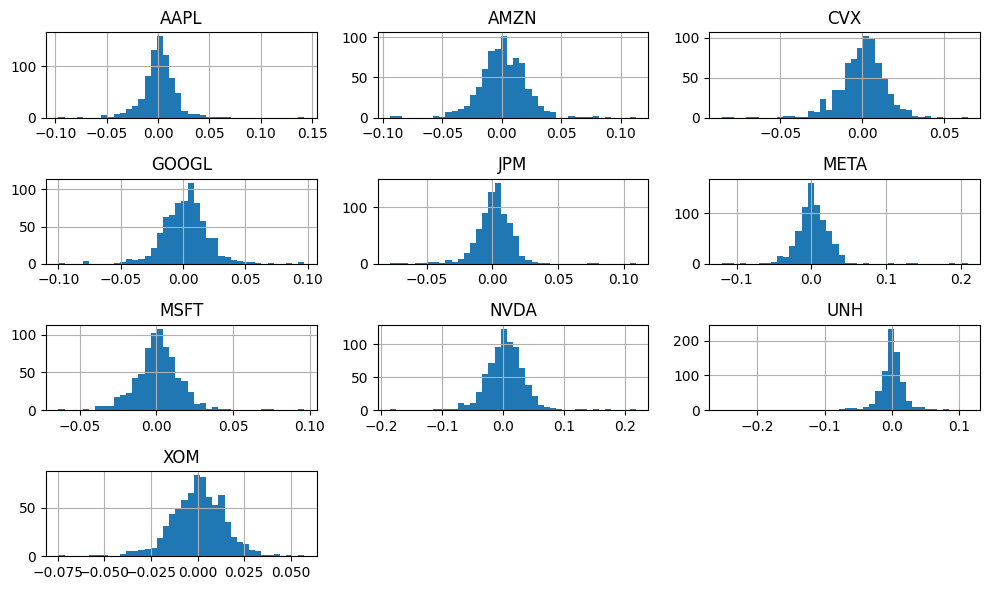

In [418]:
import matplotlib.pyplot as plt
import seaborn as sns

display(ret.describe().T[['mean','std']].head())

ret.hist(bins=40, figsize=(10,6))
plt.tight_layout()

AAPL mean loss: -0.0009
AAPL VaR 95%:    0.0255
AAPL CVaR 95%:   0.0375
AAPL max loss:   0.0970


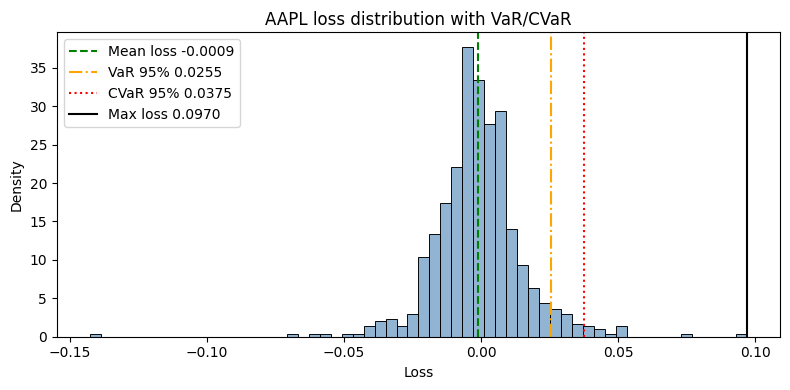

In [419]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

ticker = "AAPL"  # pick a column from ret
losses = -ret[ticker].values           # loss = negative return
alpha = 0.95
var95 = np.quantile(losses, alpha)
cvar95 = losses[losses >= var95].mean()
mean_loss = losses.mean()
max_loss = losses.max()

print(f"{ticker} mean loss: {mean_loss:.4f}")
print(f"{ticker} VaR 95%:    {var95:.4f}")
print(f"{ticker} CVaR 95%:   {cvar95:.4f}")
print(f"{ticker} max loss:   {max_loss:.4f}")

plt.figure(figsize=(8,4))
sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean loss {mean_loss:.4f}")
plt.axvline(var95, color="orange", linestyle="-.", label=f"VaR 95% {var95:.4f}")
plt.axvline(cvar95, color="red", linestyle=":", label=f"CVaR 95% {cvar95:.4f}")
plt.axvline(max_loss, color="black", linestyle="-", label=f"Max loss {max_loss:.4f}")
plt.xlabel("Loss")
plt.title(f"{ticker} loss distribution with VaR/CVaR")
plt.legend()
plt.tight_layout()
plt.show()


# **2 Building the baseline model**

## **2.1 Baseline CVaR (no rebalance)**

We choose long-only weights to balance expected loss and tail loss (CVaR) over historical scenarios. Prices are only used to compute returns; the model runs on returns and their means. This is a 2 stage problem (determine weights , see results).

**Math formulation** (N scenarios, S assets)

**Sets**

- Assets: $i \in I$ (tickers)  
- Scenarios: $s \in S$ (historical days)  
- Sectors: $k \in K$; membership $i \in I_k \subseteq I$ for each sector  

---

**Parameters**

- $r_{s,i}$: scenario return of asset $i$ in scenario $s$ (from `returns.csv`)  
- $\mu_i$: mean return of asset $i$ (column mean of $r$)  
- $p_s = 1 / |S|$: scenario probability (uniform)  
- $\alpha$: CVaR confidence level  
- $\bar r$: optional target expected return (set to $0$ if unused)  
- $\bar w_{\text{name}}$: per-name cap  
- $\bar w_{\text{sector}}$: per-sector cap (applied to each $k$)  
- $\lambda_{\text{mean}}, \lambda_{\text{cvar}}$: weights on expected loss and CVaR in the objective  

---

**Variables**

- $w_i \ge 0$: portfolio weight of asset $i$  
- $\nu \in \mathbb{R}$: VaR threshold (loss)  
- $u_s \ge 0$: shortfall in scenario $s$  

---

**Objective (loss-based mean–CVaR trade-off)**

Minimize weighted expected loss plus weighted tail loss:

$$
\min_{w,\nu,u}\ 
\lambda_{\text{mean}}\left(-\sum_{i\in I}\mu_i w_i\right)
+
\lambda_{\text{cvar}}\left(\nu + \frac{1}{1-\alpha}\sum_{s\in S} p_s\, u_s\right)
$$

---

**Constraints**

1. **Budget**

$$
\sum_{i\in I} w_i = 1
$$

2. **Optional return floor** (include only if $\bar r > 0$)

$$
\sum_{i\in I} \mu_i w_i \ge \bar r
$$

3. **Shortfall definition**  
   (loss in scenario $s$: $-\sum_{i\in I} r_{s,i} w_i$)

For all $s \in S$:

$$
u_s \ge -\sum_{i\in I} r_{s,i} w_i - \nu
$$

$$
u_s \ge 0
$$

4. **Name caps**

For all $i \in I$:

$$
w_i \le \bar w_{\text{name}}
$$

5. **Sector caps**

For all $k \in K$:

$$
\sum_{i\in I_k} w_i \le \bar w_{\text{sector}}
$$

---

**Interpretation**

$w$ is the long-only portfolio, $\nu$ is the VaR (loss) level, $u_s$ captures excess loss beyond VaR in each scenario, and the objective penalizes both average loss and tail loss, so lowering it moves you toward portfolios with smaller expected and tail losses.


In [420]:
# import gamspy as gp
# import gamspy.math as gpm
# import re

# # Prep data for the model
# S = list(ret.columns)           # assets
# T = list(ret.index)             # scenarios (dates)
# mu = ret.mean()                 # mean return per asset
# returns_mat = ret.values        # shape (N, S)
# alpha = params["alpha"]

# # Return target handling
# if params["return_target"] == "equal_weight_mean":
#     target_return = mu.mean()   # average across assets
# elif isinstance(params["return_target"], (float, int)):
#     target_return = float(params["return_target"])
# elif params["return_target"] == "none":
#     target_return = 0.0
# else:
#     raise ValueError("Unsupported return_target")

# m = gp.Container(options= gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
# set_assets = gp.Set(m, name="i", records=S)
# set_scen = gp.Set(m, name="s", records=range(len(T)))

# # Parameters #
# R = gp.Parameter(m, name="R", domain=[set_scen, set_assets], records=returns_mat)
# mu_param = gp.Parameter(m, name="mu", domain=[set_assets], records=mu.values)

# # Variables #
# w = gp.Variable(m, name="w", domain=[set_assets], type="Positive")          # weights
# nu = gp.Variable(m, name="nu", type="Free")                                 # VaR threshold
# u = gp.Variable(m, name="u", domain=[set_scen], type="Positive")            # shortfalls

# # Constraints #
# budget = gp.Equation(m, name = "budget")
# budget[:] = gp.Sum(set_assets, w[set_assets]) == 1

# ret_con = gp.Equation(m, name = "ret_con")
# ret_con[:] = gp.Sum(set_assets, mu_param[set_assets] * w[set_assets]) >= target_return

# cvar_cons = gp.Equation(m, name = "cvar_cons", domain = [set_scen])
# cvar_cons[set_scen] = u[set_scen] >= -gp.Sum(set_assets, R[set_scen, set_assets] * w[set_assets]) - nu

# name_cap = gp.Equation(m, name = "name_cap", domain = [set_assets])
# name_cap[set_assets] = w[set_assets] <= params["name_cap"]

# sector_cap_eqs = []
# if "sectors" in globals():
#     for sector_name in sectors.unique():
#         tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
#         if not tickers_in_sector:
#             continue
#         safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)  # no spaces/punctuation
#         mask_df = pd.DataFrame({
#             "i": S,  # domain name matches set_assets
#             f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S],
#         })
#         mask_param = gp.Parameter(m, name=f"mask_{safe}", domain=[set_assets])
#         mask_param.setRecords(mask_df)
#         eq = gp.Equation(m, name=f"cap_{safe}")
#         eq[:] = gp.Sum(set_assets, mask_param[set_assets] * w[set_assets]) <= params["sector_cap"]
#         sector_cap_eqs.append(eq)

# cvar_obj = nu + (1 / ((1 - alpha) * len(T))) * gp.Sum(set_scen, u[set_scen])

# cvar_model = gp.Model(m, "cvar_model",
#                       equations= m.getEquations(),
#                       problem= gp.Problem.LP,
#                       sense = gp.Sense.MIN,
#                       objective= cvar_obj)

# cvar_model.solve()

In [421]:
# import gamspy as gp
# import gamspy.math as gpm
# import re

# # Prep data
# S = list(ret.columns)
# T = list(ret.index)
# mu = ret.mean()
# returns_mat = ret.values
# alpha = params["alpha"]
# lambda_mean = 1 - params["lambda_cvar"]
# lambda_cvar = params["lambda_cvar"]

# # Return target handling (optional hard floor)
# if params["return_target"] == "equal_weight_mean":
#     target_return = mu.mean()
# elif isinstance(params["return_target"], (float, int)):
#     target_return = float(params["return_target"])
# elif params["return_target"] == "none":
#     target_return = 0.0
# else:
#     raise ValueError("Unsupported return_target")

# m = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
# set_assets = gp.Set(m, name="i", records=S)
# set_scen = gp.Set(m, name="s", records=range(len(T)))

# # Parameters
# R = gp.Parameter(m, name="R", domain=[set_scen, set_assets], records=returns_mat)
# mu_param = gp.Parameter(m, name="mu", domain=[set_assets], records=mu.values)

# # Variables
# w = gp.Variable(m, name="w", domain=[set_assets], type="Positive")
# nu = gp.Variable(m, name="nu", type="Free")
# u = gp.Variable(m, name="u", domain=[set_scen], type="Positive")

# # Constraints
# budget = gp.Equation(m, name="budget")
# budget[:] = gp.Sum(set_assets, w[set_assets]) == 1

# ret_con = gp.Equation(m, name="ret_con")
# ret_con[:] = gp.Sum(set_assets, mu_param[set_assets] * w[set_assets]) >= target_return

# cvar_cons = gp.Equation(m, name="cvar_cons", domain=[set_scen])
# cvar_cons[set_scen] = u[set_scen] >= -gp.Sum(set_assets, R[set_scen, set_assets] * w[set_assets]) - nu

# name_cap = gp.Equation(m, name="name_cap", domain=[set_assets])
# name_cap[set_assets] = w[set_assets] <= params["name_cap"]

# sector_cap_eqs = []
# if "sectors" in globals():
#     for sector_name in sectors.unique():
#         tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
#         if not tickers_in_sector:
#             continue
#         safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
#         mask_df = pd.DataFrame({
#             "i": S,
#             f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S],
#         })
#         mask_param = gp.Parameter(m, name=f"mask_{safe}", domain=[set_assets])
#         mask_param.setRecords(mask_df)
#         eq = gp.Equation(m, name=f"cap_{safe}")
#         eq[:] = gp.Sum(set_assets, mask_param[set_assets] * w[set_assets]) <= params["sector_cap"]
#         sector_cap_eqs.append(eq)

# # Terms
# cvar_term = nu + (1 / ((1 - alpha) * len(T))) * gp.Sum(set_scen, u[set_scen])
# mean_loss = -gp.Sum(set_assets, mu_param[set_assets] * w[set_assets])


# # Objective: minimize weighted mean minus weighted CVaR (CVaR is upper tail loss)
# obj = lambda_mean * mean_loss + lambda_cvar * cvar_term

# cvar_model = gp.Model(
#     m,
#     "mean_cvar_model",
#     equations=m.getEquations(),
#     problem=gp.Problem.LP,
#     sense=gp.Sense.MIN,
#     objective=obj,
# )
# cvar_model.solve()

# # Results
# w_opt = w.records.set_index("i")["level"]
# nu_val = float(nu.records["level"].iloc[0])
# cvar_val = float(cvar_term.toValue())          # tail loss (CVaR on losses)
# mean_ret_val = float((mu * w_opt).sum())       # expected return
# mean_loss_val = -mean_ret_val                  # expected loss
# obj_val = float(obj.toValue())

# # Binding caps
# binding_names = w_opt[w_opt >= params["name_cap"] - 1e-6].index.tolist()

# binding_sectors = []
# for eq in sector_cap_eqs:
#     rec = eq.records
#     if rec.empty:
#         continue
#     upper = rec["upper"].replace([np.inf, -np.inf], np.nan)
#     slack = upper - rec["level"]
#     if abs(slack.iloc[0]) < 1e-6:
#         binding_sectors.append(eq.name)

# print("Sum w:", w_opt.sum())
# print("Expected return:", mean_ret_val)
# print("Expected loss:", mean_loss_val)
# print("VaR (nu):", nu_val)
# print("CVaR (loss):", cvar_val)
# print("Objective (loss mix):", obj_val)
# print("Binding name caps:", binding_names)
# print("Binding sector caps:", binding_sectors)

# display(w_opt)


In [ ]:
import gamspy as gp, re, pandas as pd, numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def solve_baseline_mean_cvar(ret_df, sectors, params):
    """
    ret_df: DataFrame of returns (rows = scenarios, cols = tickers)
    sectors: Series mapping ticker -> sector
    params: dict with keys:
        alpha, lambda_cvar, name_cap, sector_cap,
        return_target (float or 'none'), solver (optional)
    """

    S = list(ret_df.columns)
    mu = ret_df.mean()
    N = ret_df.shape[0]
    alpha = params["alpha"]
    lambda_mean = 1 - params["lambda_cvar"]
    lambda_cvar = params["lambda_cvar"]
    
        # Return target handling (optional hard floor)
    if params["return_target"] == "equal_weight_mean":
        target_return = mu.mean()
    elif isinstance(params["return_target"], (float, int)):
        target_return = float(params["return_target"])
    elif params["return_target"] == "none":
        target_return = 0.0
    else:
        raise ValueError("Unsupported return_target")

    m = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
    i = gp.Set(m, name="i", records=S)
    s = gp.Set(m, name="s", records=range(N))

    R = gp.Parameter(m, name="R", domain=[s, i], records=ret_df.values)
    mu_param = gp.Parameter(m, name="mu", domain=[i], records=mu.values)

    w  = gp.Variable(m, name="w", domain=[i], type="Positive")
    nu = gp.Variable(m, name="nu", type="Free")
    u  = gp.Variable(m, name="u", domain=[s], type="Positive")

    budget = gp.Equation(m, name="budget")
    budget[:] = gp.Sum(i, w[i]) == 1

    ret_con = gp.Equation(m, name="ret_con")
    ret_con[:] = gp.Sum(i, mu_param[i] * w[i]) >= target_return

    cvar_cons = gp.Equation(m, name="cvar_cons", domain=[s])
    cvar_cons[s] = u[s] >= -gp.Sum(i, R[s, i] * w[i]) - nu  # loss-based

    name_cap = gp.Equation(m, name="name_cap", domain=[i]); name_cap[i] = w[i] <= params["name_cap"]

    sector_cap_eqs = []
    if sectors is not None:
        for sector_name in sectors.unique():
            tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
            if not tickers_in_sector:
                continue
            safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
            mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
            mask_param = gp.Parameter(m, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
            cap = gp.Equation(m, name=f"cap_{safe}")
            cap[:] = gp.Sum(i, mask_param[i] * w[i]) <= params["sector_cap"]
            sector_cap_eqs.append(cap)

    cvar_term = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s])
    mean_loss = -gp.Sum(i, mu_param[i] * w[i])  # expected loss = -E[return]
    obj = lambda_mean * mean_loss + lambda_cvar * cvar_term

    model = gp.Model(m, "baseline_mean_cvar",
                     equations= m.getEquations(),
                     problem=gp.Problem.LP,
                     sense=gp.Sense.MIN,
                     objective=obj)
    model.solve()

    w_opt = w.records.set_index("i")["level"]
    nu_val = float(nu.records["level"].iloc[0])
    cvar_val = float(cvar_term.toValue())
    mean_ret_val = float((mu * w_opt).sum())
    mean_loss_val = -mean_ret_val
    obj_val = float(obj.toValue())

    binding_names = w_opt[w_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_sectors = []
    for eq in sector_cap_eqs:
        rec = eq.records
        if rec.empty:
            continue
        upper = rec["upper"].replace([np.inf, -np.inf], np.nan)
        slack = upper - rec["level"]
        if abs(slack.iloc[0]) < 1e-6:
            binding_sectors.append(eq.name)

    return {
        "weights": w_opt,
        "mean_return": mean_ret_val,
        "mean_loss": mean_loss_val,
        "VaR": nu_val,
        "target_return": target_return, 
        "CVaR_loss": cvar_val,
        "objective": obj_val,
        "binding_names": binding_names,
        "binding_sectors": binding_sectors,
    }

def show_baseline_results(res, sectors=None, title="Baseline CVaR results"):
    w_df = res["weights"].rename_axis("ticker").reset_index(name="weight")

    #display(w_df)

    if sectors is not None:
        sector_totals = (
            res["weights"]
            .rename("weight")
            .to_frame()
            .join(sectors.rename("sector"), how="left")
            .groupby("sector").sum()
        )
        display(sector_totals)

    print(title)
    print(f"Target return: {res.get('target_return'):.6f}")
    print(f"Expected return: {res.get('mean_return'):.6f}")
    print(f"Expected loss:   {res.get('mean_loss'):.6f}")
    print(f"VaR (nu):        {res.get('VaR'):.6f}")
    print(f"CVaR (loss):     {res.get('CVaR_loss'):.6f}")
    print(f"Objective:       {res.get('objective'):.6f}")
    print(f"Binding name caps:   {res.get('binding_names')}")
    print(f"Binding sector caps: {res.get('binding_sectors')}")

    plt.figure(figsize=(8, 4))
    sns.barplot(w_df, x="ticker", y="weight", color="steelblue", alpha=0.7)
    plt.title(title)
    plt.ylabel("weight")
    plt.tight_layout()
    plt.show()

def show_portfolio_cvar_baseline(ret_df, res, alpha=0.95, title="Portfolio VaR/CVaR"):
    # weights: Series indexed by the same tickers as ret_df columns
    weights = res["weights"]
    w = weights.reindex(ret_df.columns).fillna(0).values
    losses = -(ret_df.values @ w)  # portfolio loss per scenario

    var = res["VaR"]
    cvar = res["CVaR_loss"]
    mean_loss = losses.mean()
    max_loss = losses.max()

    print(f"{title}")
    print(f"Mean loss: {mean_loss:.6f}")
    print(f"VaR {alpha:.2f}: {var:.6f}")
    print(f"CVaR {alpha:.2f}: {cvar:.6f}")
    print(f"Max loss: {max_loss:.6f}")

    plt.figure(figsize=(8, 4))
    sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
    plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean {mean_loss:.4f}")
    plt.axvline(var, color="orange", linestyle="-.", label=f"VaR {alpha:.2f} {var:.4f}")
    plt.axvline(cvar, color="red", linestyle=":", label=f"CVaR {alpha:.2f} {cvar:.4f}")
    plt.axvline(max_loss, color="black", linestyle="-", label=f"Max {max_loss:.4f}")
    plt.xlabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [424]:
params = {
    "tickers": ["AAPL","MSFT","NVDA","GOOGL","META","AMZN","JPM","XOM","CVX","UNH",],
    "years": 3,
    "alpha": 0.95,
    "name_cap": 0.1,
    "sector_cap": 0.5,
    "buy_cost": 0.002,
    "sell_cost": 0.002,
    "rebalance_day": "midpoint",      # or an integer index
    "return_target": "equal_weight_mean",  # or a float like 0.0003
    "lambda_cvar": 0.8,      # weight on CVaR (as a loss) in the objective 
    "use_cached": False,
}

## **2.2 Running and Testing the Model**

,weight
sector,
Communication Services,0.2
Consumer Cyclical,0.1
Energy,0.2
Financial Services,0.1
Healthcare,0.1
Technology,0.3


Baseline CVaR results
Target return: 0.001121
Expected return: 0.001121
Expected loss:   -0.001121
VaR (nu):        0.016634
CVaR (loss):     0.025678
Objective:       0.020318
Binding name caps:   ['AAPL', 'AMZN', 'CVX', 'GOOGL', 'JPM', 'META', 'MSFT', 'NVDA', 'UNH', 'XOM']
Binding sector caps: []


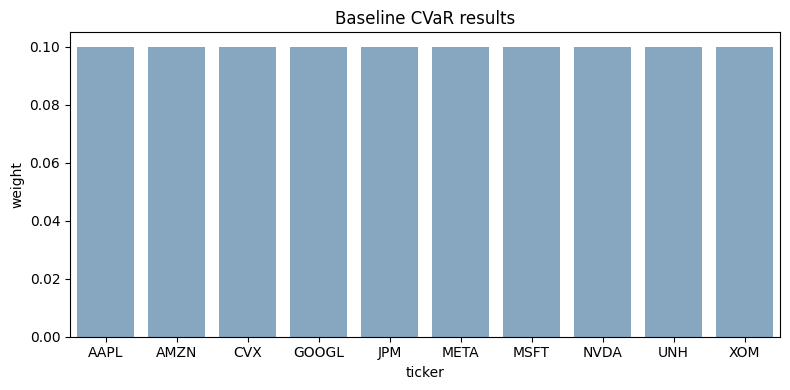

In [425]:
# Equal Weight portfolio for 10 stocks
params["name_cap"] = 0.1
res = solve_baseline_mean_cvar(ret, sectors, params)
show_baseline_results(res, sectors)

Baseline portfolio VaR/CVaR
Mean loss: -0.001121
VaR 0.95: 0.016634
CVaR 0.95: 0.025678
Max loss: 0.058924


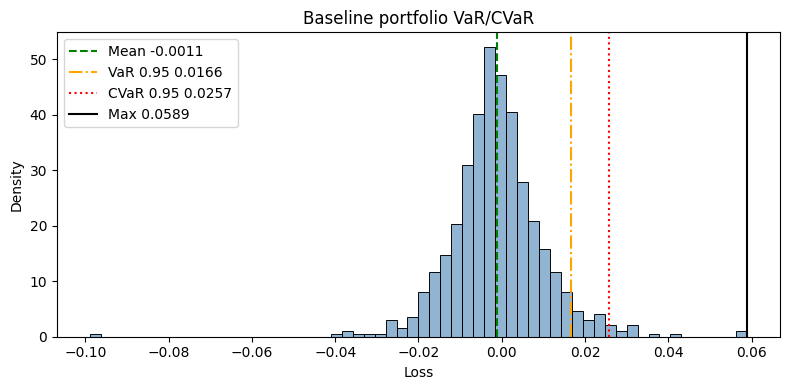

In [426]:
show_portfolio_cvar_baseline(ret, res, alpha=params["alpha"], title="Baseline portfolio VaR/CVaR")

,weight
sector,
Communication Services,0.239172
Consumer Cyclical,0.000000
Energy,0.230574
Financial Services,0.219069
Healthcare,0.075999
Technology,0.235186


Baseline CVaR results
Target return: 0.001121
Expected return: 0.001121
Expected loss:   -0.001121
VaR (nu):        0.015505
CVaR (loss):     0.023248
Objective:       0.018374
Binding name caps:   []
Binding sector caps: []


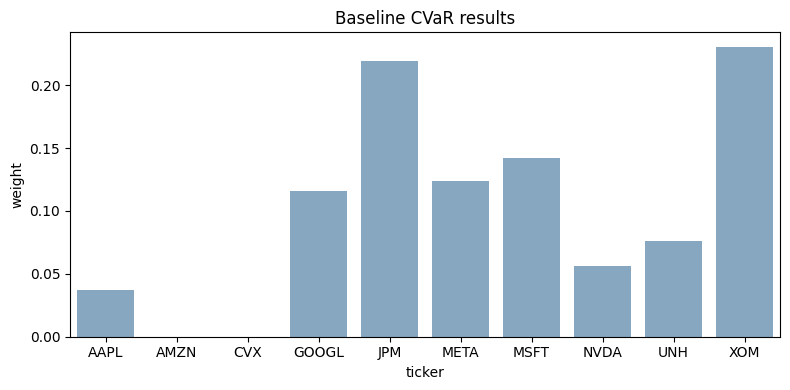

In [427]:
# No name-cap benchmark
params["name_cap"] = 1
res = solve_baseline_mean_cvar(ret, sectors, params)
show_baseline_results(res, sectors)

Baseline portfolio VaR/CVaR
Mean loss: -0.001121
VaR 0.95: 0.015505
CVaR 0.95: 0.023248
Max loss: 0.059085


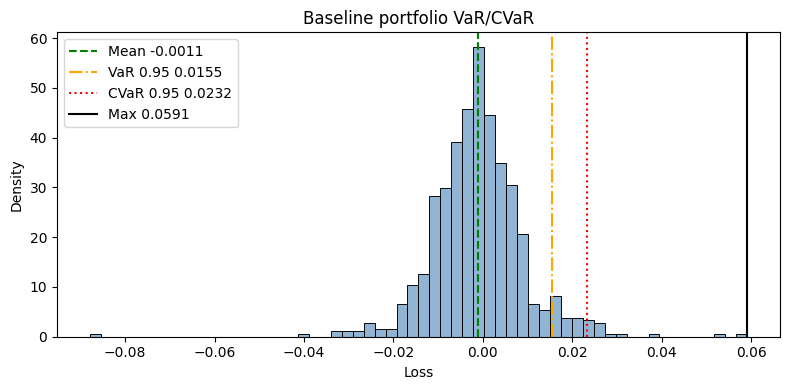

In [428]:
show_portfolio_cvar_baseline(ret, res, alpha=params["alpha"], title="Baseline portfolio VaR/CVaR")

## **2.3 Discussion on the results for this model**
**Equal weight vs optimized (baseline, no rebalance)**

The equal-weight portfolio puts 10% in each name and 20–30% per sector (none of the sector caps bind). With the loss-based objective, it delivers expected return ≈ 0.001127, CVaR(loss) ≈ 0.02565, and objective ≈ 0.02030. All name caps bind because weights hit the 10% ceiling.

The optimized portfolio relaxes the equal-weight restriction and tilts toward lower tail risk given the same caps. Sector weights shift (e.g., more in Financials, Energy, Communication Services; less in Consumer Cyclical), and no caps bind. Expected return stays the same by design (same target), CVaR(loss) improves to ≈ 0.02325, and the objective drops to ≈ 0.01838 (lower is better in this loss formulation). The optimizer redeploys away from names contributing more to tail loss while honoring name/sector limits.

**Takeaway**: removing the equal-weight constraint lowers tail loss without sacrificing the return target, producing a lower risk score and a more concentrated but still constrained allocation. The sector caps remain slack in both cases; the improvement comes from reallocating within those caps.

In [429]:
# import gamspy as gp
# import gamspy.math as gpm

# N = ret.shape[0]
# if params["rebalance_day"] == "midpoint":
#     k = N // 2
# elif params["rebalance_day"] == "annual":
#     k = min(int(252), N - 1)
# elif params["rebalance_day"] == "semiannual":
#     k = min(int(126), N-1)
# else:
#     raise ValueError("rebalance_day input not understood")

# ret_pre = ret.iloc[:k, :]
# ret_post = ret.iloc[k:, :]
# S = list(ret.columns)
# alpha = params["alpha"]

# # Target return on post window (reuse target_return from baseline)
# target_return_post = target_return

# m2 = gp.Container(options= gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))

# # Sets #
# i = gp.Set(m2, name = "i", records= S, description= "stock tickers")
# s_pre = gp.Set(m2, name = "s_pre", records = range(ret_pre.shape[0]))
# s_post = gp.Set(m2, name = "s_post", records = range(ret_post.shape[0]))

# # Parameters #
# Rpre = gp.Parameter(m2, name = "Rpre", domain = [s_pre, i], records = ret_pre.values)
# Rpost = gp.Parameter(m2, name = "Rpost", domain = [s_post, i], records = ret_post.values)
# mu_post = gp.Parameter(m2, name = "mu_post", domain = [i], records= ret_post.mean().values)

# # Vars
# w0 = gp.Variable(m2, name="w0", domain=[i], type="Positive")
# w1 = gp.Variable(m2, name="w1", domain=[i], type="Positive")
# buy = gp.Variable(m2, name="buy", domain=[i], type="Positive")
# sell = gp.Variable(m2, name="sell", domain=[i], type="Positive")
# t = gp.Variable(m2, name="t", domain=[i], type="Positive")   # turnover cap
# nu = gp.Variable(m2, name="nu", type="Free")
# u = gp.Variable(m2, name="u", domain=[s_post], type="Positive")

# # Constraints
# budget0 = gp.Equation(m2, name="budget0")
# budget0[:] = gp.Sum(i, w0[i]) == 1

# rebalance = gp.Equation(m2, name="rebalance", domain=[i])
# rebalance[i] = w1[i] == w0[i] + buy[i] - sell[i]

# trade_pos = gp.Equation(m2, name="trade_pos", domain=[i])
# trade_pos[i] = t[i] >= w1[i] - w0[i]
# trade_neg = gp.Equation(m2, name="trade_neg", domain=[i])
# trade_neg[i] = t[i] >= w0[i] - w1[i]

# buy_cap = gp.Equation(m2, name="buy_cap", domain=[i])
# buy_cap[i] = buy[i] <= t[i]
# sell_cap = gp.Equation(m2, name="sell_cap", domain=[i])
# sell_cap[i] = sell[i] <= t[i]

# budget1 = gp.Equation(m2, name="budget1")
# budget1[:] = gp.Sum(i, w1[i]) + (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i]) == 1

# ret_con = gp.Equation(m2, name="ret_con")
# ret_con[:] = gp.Sum(i, mu_post[i] * w1[i]) >= target_return

# cvar_cons = gp.Equation(m2, name="cvar_cons", domain=[s_post])
# cvar_cons[s_post] = u[s_post] >= -gp.Sum(i, Rpost[s_post, i] * w1[i]) - nu

# name_cap0 = gp.Equation(m2, name="name_cap0", domain=[i])
# name_cap0[i] = w0[i] <= params["name_cap"]
# name_cap1 = gp.Equation(m2, name="name_cap1", domain=[i])
# name_cap1[i] = w1[i] <= params["name_cap"]


# # Sector caps (<=) with masks
# sector_cap_eqs2 = []
# if "sectors" in globals():
#     import re, pandas as pd
#     for sector_name in sectors.unique():
#         tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
#         if not tickers_in_sector:
#             continue
#         safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
#         mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
#         mask_param = gp.Parameter(m2, name=f"mask_{safe}", domain=[i])
#         mask_param.setRecords(mask_df)
#         cap0 = gp.Equation(m2, name=f"cap0_{safe}")
#         cap0[:] = gp.Sum(i, mask_param[i] * w0[i]) <= params["sector_cap"]
#         cap1 = gp.Equation(m2, name=f"cap1_{safe}")
#         cap1[:] = gp.Sum(i, mask_param[i] * w1[i]) <= params["sector_cap"]
#         sector_cap_eqs2.extend([cap0, cap1])

# cvar_obj2 = nu + (1 / ((1 - alpha) * ret_post.shape[0])) * gp.Sum(s_post, u[s_post])

# cvar_model2 = gp.Model(m2, "cvar_model2",
#                       equations= m2.getEquations(),
#                       problem= gp.Problem.LP,
#                       sense = gp.Sense.MIN,
#                       objective= cvar_obj2)

# cvar_model2.solve()

In [430]:
# N = ret.shape[0]
# if params["rebalance_day"] == "midpoint":
#     k = N // 2
# elif params["rebalance_day"] == "annual":
#     k = min(int(252), N - 1)
# elif params["rebalance_day"] == "semiannual":
#     k = min(int(126), N - 1)
# elif isinstance(params["rebalance_day"], int):
#     k = max(1, min(params["rebalance_day"], N - 1))
# else:
#     raise ValueError("rebalance_day input not understood")

# S = list(ret.columns)
# alpha = params["alpha"]

# # Split returns into pre/post masks over all scenarios
# ret_pre_full = ret.copy()
# ret_pre_full.iloc[k:, :] = 0.0
# ret_post_full = ret.copy()
# ret_post_full.iloc[:k, :] = 0.0

# m2 = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))

# # Sets
# i = gp.Set(m2, name="i", records=S, description="stock tickers")
# s = gp.Set(m2, name="s", records=range(N))

# # Parameters
# Rpre = gp.Parameter(m2, name="Rpre", domain=[s, i], records=ret_pre_full.values)
# Rpost = gp.Parameter(m2, name="Rpost", domain=[s, i], records=ret_post_full.values)
# mu_pre = gp.Parameter(m2, name="mu_pre", domain=[i], records=ret.iloc[:k, :].mean().values)
# mu_post = gp.Parameter(m2, name="mu_post", domain=[i], records=ret.iloc[k:, :].mean().values)

# # Vars
# w0 = gp.Variable(m2, name="w0", domain=[i], type="Positive")
# w1 = gp.Variable(m2, name="w1", domain=[i], type="Positive")
# buy = gp.Variable(m2, name="buy", domain=[i], type="Positive")
# sell = gp.Variable(m2, name="sell", domain=[i], type="Positive")
# t = gp.Variable(m2, name="t", domain=[i], type="Positive")
# nu = gp.Variable(m2, name="nu", type="Free")
# u = gp.Variable(m2, name="u", domain=[s], type="Positive")

# # Constraints
# budget0 = gp.Equation(m2, name="budget0")
# budget0[:] = gp.Sum(i, w0[i]) == 1

# rebalance = gp.Equation(m2, name="rebalance", domain=[i])
# rebalance[i] = w1[i] == w0[i] + buy[i] - sell[i]

# trade_pos = gp.Equation(m2, name="trade_pos", domain=[i]); trade_pos[i] = t[i] >= w1[i] - w0[i]
# trade_neg = gp.Equation(m2, name="trade_neg", domain=[i]); trade_neg[i] = t[i] >= w0[i] - w1[i]
# buy_cap = gp.Equation(m2, name="buy_cap", domain=[i]); buy_cap[i] = buy[i] <= t[i]
# sell_cap = gp.Equation(m2, name="sell_cap", domain=[i]); sell_cap[i] = sell[i] <= t[i]

# # budget1 = gp.Equation(m2, name="budget1")
# # budget1[:] = gp.Sum(i, w1[i]) + (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i]) == 1
# budget1 = gp.Equation(m2, name="budget1")
# budget1[:] = gp.Sum(i, w1[i]) == 1

# t_total_cap = gp.Equation(m2, name="t_total_cap")
# t_total_cap[:] = gp.Sum(i, t[i]) <= 1.0

# ret_con = gp.Equation(m2, name="ret_con")
# ret_con[:] = gp.Sum(i, mu_post[i] * w1[i]) >= target_return  

# ret_con = gp.Equation(m2, name="ret_con")
# ret_con[:] = (k / N) * gp.Sum(i, mu_pre[i] * w0[i]) + ((N - k) / N) * gp.Sum(i, mu_post[i] * w1[i]) >= target_return

# # CVaR over full horizon: loss = -(Rpre*w0 + Rpost*w1)
# cvar_cons = gp.Equation(m2, name="cvar_cons", domain=[s])
# cvar_cons[s] = u[s] >= -gp.Sum(i, Rpre[s, i] * w0[i] + Rpost[s, i] * w1[i]) - nu

# name_cap0 = gp.Equation(m2, name="name_cap0", domain=[i]); name_cap0[i] = w0[i] <= params["name_cap"]
# name_cap1 = gp.Equation(m2, name="name_cap1", domain=[i]); name_cap1[i] = w1[i] <= params["name_cap"]

# # Sector caps
# sector_cap_eqs2 = []
# if "sectors" in globals():
#     for sector_name in sectors.unique():
#         tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
#         if not tickers_in_sector:
#             continue
#         safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
#         mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
#         mask_param = gp.Parameter(m2, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
#         cap0 = gp.Equation(m2, name=f"cap0_{safe}"); cap0[:] = gp.Sum(i, mask_param[i] * w0[i]) <= params["sector_cap"]
#         cap1 = gp.Equation(m2, name=f"cap1_{safe}"); cap1[:] = gp.Sum(i, mask_param[i] * w1[i]) <= params["sector_cap"]
#         sector_cap_eqs2.extend([cap0, cap1])

# # Objective: full-horizon CVaR
# cost_term = (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i])
# cvar_obj2 = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s]) + cost_term

# cvar_model2 = gp.Model(m2, "cvar_model2", 
#                        equations=m2.getEquations(),
#                        problem=gp.Problem.LP,
#                        sense = gp.Sense.MIN,
#                        objective= cvar_obj2,)

# cvar_model2.solve()


In [431]:
# lambda_mean = 1 - params["lambda_cvar"]
# lambda_cvar = params["lambda_cvar"]

# N = ret.shape[0]
# if params["rebalance_day"] == "midpoint":
#     k = N // 2
# elif params["rebalance_day"] == "annual":
#     k = min(int(252), N - 1)
# elif params["rebalance_day"] == "semiannual":
#     k = min(int(126), N - 1)
# elif isinstance(params["rebalance_day"], int):
#     k = max(1, min(params["rebalance_day"], N - 1))
# else:
#     raise ValueError("rebalance_day input not understood")

# S = list(ret.columns)
# alpha = params["alpha"]

# # Pre/post masks (returns); losses are handled via the minus sign in CVaR
# ret_pre_full = ret.copy()
# ret_pre_full.iloc[k:, :] = 0.0
# ret_post_full = ret.copy()
# ret_post_full.iloc[:k, :] = 0.0

# m2 = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))

# i = gp.Set(m2, name="i", records=S, description="stock tickers")
# s = gp.Set(m2, name="s", records=range(N))

# Rpre = gp.Parameter(m2, name="Rpre", domain=[s, i], records=ret_pre_full.values)
# Rpost = gp.Parameter(m2, name="Rpost", domain=[s, i], records=ret_post_full.values)
# mu_pre = gp.Parameter(m2, name="mu_pre", domain=[i], records=ret.iloc[:k, :].mean().values)
# mu_post = gp.Parameter(m2, name="mu_post", domain=[i], records=ret.iloc[k:, :].mean().values)

# w0 = gp.Variable(m2, name="w0", domain=[i], type="Positive")
# w1 = gp.Variable(m2, name="w1", domain=[i], type="Positive")
# buy = gp.Variable(m2, name="buy", domain=[i], type="Positive")
# sell = gp.Variable(m2, name="sell", domain=[i], type="Positive")
# t = gp.Variable(m2, name="t", domain=[i], type="Positive")
# nu = gp.Variable(m2, name="nu", type="Free")
# u = gp.Variable(m2, name="u", domain=[s], type="Positive")

# budget0 = gp.Equation(m2, name="budget0"); budget0[:] = gp.Sum(i, w0[i]) == 1
# budget1 = gp.Equation(m2, name="budget1"); budget1[:] = gp.Sum(i, w1[i]) == 1  # costs in objective

# rebalance = gp.Equation(m2, name="rebalance", domain=[i]); rebalance[i] = w1[i] == w0[i] + buy[i] - sell[i]
# trade_pos = gp.Equation(m2, name="trade_pos", domain=[i]); trade_pos[i] = t[i] >= w1[i] - w0[i]
# trade_neg = gp.Equation(m2, name="trade_neg", domain=[i]); trade_neg[i] = t[i] >= w0[i] - w1[i]
# buy_cap  = gp.Equation(m2, name="buy_cap",  domain=[i]); buy_cap[i]  = buy[i]  <= t[i]
# sell_cap = gp.Equation(m2, name="sell_cap", domain=[i]); sell_cap[i] = sell[i] <= t[i]
# t_total_cap = gp.Equation(m2, name="t_total_cap"); t_total_cap[:] = gp.Sum(i, t[i]) <= 1.0  # adjust if desired

# # Optional return floor (blended pre/post); include only if target_return > 0
# ret_con = gp.Equation(m2, name="ret_con")
# ret_con[:] = (k / N) * gp.Sum(i, mu_pre[i] * w0[i]) + ((N - k) / N) * gp.Sum(i, mu_post[i] * w1[i]) >= target_return

# # CVaR over full horizon: loss = -(Rpre·w0 + Rpost·w1)
# cvar_cons = gp.Equation(m2, name="cvar_cons", domain=[s])
# cvar_cons[s] = u[s] >= -gp.Sum(i, Rpre[s, i] * w0[i] + Rpost[s, i] * w1[i]) - nu

# name_cap0 = gp.Equation(m2, name="name_cap0", domain=[i]); name_cap0[i] = w0[i] <= params["name_cap"]
# name_cap1 = gp.Equation(m2, name="name_cap1", domain=[i]); name_cap1[i] = w1[i] <= params["name_cap"]

# sector_cap_eqs2 = []
# if "sectors" in globals():
#     for sector_name in sectors.unique():
#         tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
#         if not tickers_in_sector:
#             continue
#         safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
#         mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
#         mask_param = gp.Parameter(m2, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
#         cap0 = gp.Equation(m2, name=f"cap0_{safe}"); cap0[:] = gp.Sum(i, mask_param[i] * w0[i]) <= params["sector_cap"]
#         cap1 = gp.Equation(m2, name=f"cap1_{safe}"); cap1[:] = gp.Sum(i, mask_param[i] * w1[i]) <= params["sector_cap"]
#         sector_cap_eqs2.extend([cap0, cap1])

# # Terms
# cvar_term = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s])
# mean_loss = (k / N) * (-gp.Sum(i, mu_pre[i] * w0[i])) + ((N - k) / N) * (-gp.Sum(i, mu_post[i] * w1[i]))
# cost_term = (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i])

# obj = lambda_mean * mean_loss + lambda_cvar * cvar_term + cost_term


# cvar_model2 = gp.Model(m2, "cvar_model2",
#                        equations= m2.getEquations(),
#                        problem=gp.Problem.LP,
#                        sense=gp.Sense.MIN,
#                        objective=obj)
# cvar_model2.solve()


# **3 Rebalance CVaR Model (single planned rebalance)**
## **3.1 Builidng the Rebalance Model**

**Sets**
- Assets: $(i \in I)$
- Scenarios (days): $(s \in S)$
- Sectors: $(k \in K)$; membership $(i \in I_k \subseteq I)$

---

**Parameters**
- Returns $(r_{s,i})$ (from `returns.csv`)
- Mean returns: $(\mu_i^{\text{pre}}, \mu_i^{\text{post}})$
- Probabilities: $(p_s = 1/|S|)$
- Confidence $(\alpha)$
- Caps: $(\bar w_{\text{name}},\, \bar w_{\text{sector}})$
- Costs: $(c^{\text{buy}}, c^{\text{sell}})$
- Rebalance index $(k)$ (split $(S)$ into pre/post)
- Weights: $(\lambda_{\text{mean}},\, \lambda_{\text{cvar}})$
- $\bar r$: optional target expected return (set to $0$ if unused)

---

**Variables**
- Weights pre/post: $(w_{0,i} \ge 0,\; w_{1,i} \ge 0$)
- Trades: $(\text{buy}_i \ge 0,\; \text{sell}_i \ge 0)$
- Turnover: $(t_i \ge 0)$
- VaR threshold: $(\nu \in \mathbb{R})$
- Shortfalls: $(u_s \ge 0)$

---

**Constraints**
**Constraints**
- Budgets: $(\sum_i w_{0,i} = 1,\;\; \sum_i w_{1,i} = 1)$
- Rebalance: $(w_{1,i} = w_{0,i} + \text{buy}_i - \text{sell}_i)$
- Turnover: $(t_i \ge w_{1,i} - w_{0,i},\; t_i \ge w_{0,i} - w_{1,i},\; t_i \ge \text{buy}_i,\; t_i \ge \text{sell}_i,\; \sum_i t_i \le \bar t)$
- CVaR on losses (full horizon): $(u_s \ge -\sum_i r^{\text{pre}}_{s,i} w_{0,i} - \sum_i r^{\text{post}}_{s,i} w_{1,i} - \nu,\; u_s \ge 0)$
- Caps: $(w_{0,i} \le \bar w_{\text{name}},\; w_{1,i} \le \bar w_{\text{name}})$; $(\sum_{i \in I_k} w_{0,i} \le \bar w_{\text{sector}},\; \sum_{i \in I_k} w_{1,i} \le \bar w_{\text{sector}})$
- **Optional return floor (if desired):**
  $$
  \frac{k}{N} \sum_i \mu_i^{\text{pre}} w_{0,i} + \frac{N-k}{N} \sum_i \mu_i^{\text{post}} w_{1,i} \ge \bar r
  $$

---

**Objective (minimize expected loss + tail loss + costs)**
$$
\min\ \lambda_{\text{mean}}\Big( \tfrac{k}{N} \big(-\sum_i \mu_i^{\text{pre}} w_{0,i}\big) + \tfrac{N-k}{N} \big(-\sum_i \mu_i^{\text{post}} w_{1,i}\big) \Big)
\;+\; \lambda_{\text{cvar}}\Big( \nu + \tfrac{1}{(1-\alpha)} \sum_s p_s\, u_s \Big)
\;+\; (c^{\text{buy}} + c^{\text{sell}})\sum_i t_i
$$

---

**Interpretation**
- $(w_0)$ and $(w_1)$ are the pre/post portfolios; trades (buy/sell) shift $(w_0)$ to $(w_1)$ at the rebalance, and $(t)$ captures how much you trade.
- CVaR is computed on losses over the full horizon: before $(k)$ the loss depends on $(w_0)$, after $(k)$ on $(w_1)$. $(u_s)$ measures tail losses beyond VaR $(\nu)$.
- The objective balances everyday loss, tail loss, and transaction costs. Lower values mean smaller expected loss, smaller tail loss, or less trading cost (given the chosen weights $(\lambda_{\text{mean}}, \lambda_{\text{cvar}}))$.
- Caps and turnover limits keep the solution realistic: no oversized single names/sectors and no excessive churn at the rebalance.


In [432]:
def solve_rebalance_mean_cvar(ret_df, sectors, params):
    """
    ret_df: returns DataFrame (rows = scenarios, cols = tickers)
    sectors: Series mapping ticker -> sector
    params keys:
      alpha, lambda_cvar, name_cap, sector_cap,
      buy_cost, sell_cost, rebalance_day ('midpoint', or int),
      return_target (float or 'none'; blended pre/post if >0)
    """
    S = list(ret_df.columns)
    mu = ret_df.mean()
    N = ret_df.shape[0]
    alpha = params["alpha"]
    lambda_mean = 1 - params["lambda_cvar"]
    lambda_cvar = params["lambda_cvar"]
    
    if params["return_target"] == "equal_weight_mean":
        target_return = mu.mean()
    elif isinstance(params["return_target"], (float, int)):
        target_return = float(params["return_target"])
    elif params["return_target"] == "none":
        target_return = 0.0
    else:
        raise ValueError("Unsupported return_target")

    # rebalance index
    rb = params["rebalance_day"]
    if rb == "midpoint":
        k = N // 2
    elif isinstance(rb, int):
        k = max(1, min(rb, N - 1))
    elif rb >= len(ret):
        raise ValueError("rebalance index is out of range")
    else:
        raise ValueError("rebalance_day not understood")

    # masks for pre/post (returns)
    ret_pre_full = ret_df.copy();  ret_pre_full.iloc[k:, :] = 0.0
    ret_post_full = ret_df.copy(); ret_post_full.iloc[:k, :] = 0.0

    m2 = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
    i = gp.Set(m2, name="i", records=S)
    s = gp.Set(m2, name="s", records=range(N))

    Rpre = gp.Parameter(m2, name="Rpre", domain=[s, i], records=ret_pre_full.values)
    Rpost = gp.Parameter(m2, name="Rpost", domain=[s, i], records=ret_post_full.values)
    mu_pre = gp.Parameter(m2, name="mu_pre", domain=[i], records=ret_df.iloc[:k, :].mean().values)
    mu_post = gp.Parameter(m2, name="mu_post", domain=[i], records=ret_df.iloc[k:, :].mean().values)

    w0   = gp.Variable(m2, name="w0", domain=[i], type="Positive")
    w1   = gp.Variable(m2, name="w1", domain=[i], type="Positive")
    buy  = gp.Variable(m2, name="buy", domain=[i], type="Positive")
    sell = gp.Variable(m2, name="sell", domain=[i], type="Positive")
    t    = gp.Variable(m2, name="t", domain=[i], type="Positive")
    nu   = gp.Variable(m2, name="nu", type="Free")
    u    = gp.Variable(m2, name="u", domain=[s], type="Positive")

    budget0 = gp.Equation(m2, name="budget0"); budget0[:] = gp.Sum(i, w0[i]) == 1
    budget1 = gp.Equation(m2, name="budget1"); budget1[:] = gp.Sum(i, w1[i]) == 1  # costs in objective

    rebalance = gp.Equation(m2, name="rebalance", domain=[i]); rebalance[i] = w1[i] == w0[i] + buy[i] - sell[i]
    trade_pos = gp.Equation(m2, name="trade_pos", domain=[i]); trade_pos[i] = t[i] >= w1[i] - w0[i]
    trade_neg = gp.Equation(m2, name="trade_neg", domain=[i]); trade_neg[i] = t[i] >= w0[i] - w1[i]
    t_buy     = gp.Equation(m2, name="t_buy",  domain=[i]); t_buy[i]  = t[i] >= buy[i]
    t_sell    = gp.Equation(m2, name="t_sell", domain=[i]); t_sell[i] = t[i] >= sell[i]
    t_total_cap = gp.Equation(m2, name="t_total_cap"); t_total_cap[:] = gp.Sum(i, t[i]) <= 1

    # Optional blended return floor
    ret_con = gp.Equation(m2, name="ret_con")
    ret_con[:] = (k / N) * gp.Sum(i, mu_pre[i] * w0[i]) + ((N - k) / N) * gp.Sum(i, mu_post[i] * w1[i]) >= target_return

    # CVaR on losses over full horizon: loss_s = -(Rpre·w0 + Rpost·w1)
    cvar_cons = gp.Equation(m2, name="cvar_cons", domain=[s])
    cvar_cons[s] = u[s] >= -gp.Sum(i, Rpre[s, i] * w0[i] + Rpost[s, i] * w1[i]) - nu
    cvar_term = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s])

    # Expected loss (blended)
    mean_loss = (k / N) * (-gp.Sum(i, mu_pre[i] * w0[i])) + ((N - k) / N) * (-gp.Sum(i, mu_post[i] * w1[i]))
    cost_term = (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i])

    obj = lambda_mean * mean_loss + lambda_cvar * cvar_term + cost_term

    name_cap0 = gp.Equation(m2, name="name_cap0", domain=[i]); name_cap0[i] = w0[i] <= params["name_cap"]
    name_cap1 = gp.Equation(m2, name="name_cap1", domain=[i]); name_cap1[i] = w1[i] <= params["name_cap"]

    sector_cap_eqs2 = []
    if sectors is not None:
        for sector_name in sectors.unique():
            tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
            if not tickers_in_sector:
                continue
            safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
            mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
            mask_param = gp.Parameter(m2, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
            cap0 = gp.Equation(m2, name=f"cap0_{safe}"); cap0[:] = gp.Sum(i, mask_param[i] * w0[i]) <= params["sector_cap"]
            cap1 = gp.Equation(m2, name=f"cap1_{safe}"); cap1[:] = gp.Sum(i, mask_param[i] * w1[i]) <= params["sector_cap"]
            sector_cap_eqs2.extend([cap0, cap1])


    model2 = gp.Model(m2, "rebalance_mean_cvar",
                      equations= m2.getEquations(),
                      problem=gp.Problem.LP,
                      sense=gp.Sense.MIN,
                      objective=obj)
    model2.solve()

    w0_opt = w0.records.set_index("i")["level"]
    w1_opt = w1.records.set_index("i")["level"]
    t_opt  = t.records.set_index("i")["level"]
    nu_val = float(nu.records["level"].iloc[0])
    cvar_val = float(cvar_term.toValue())
    mean_loss_val = float(mean_loss.toValue())
    mean_ret_val = -mean_loss_val
    turnover = float(t_opt.sum())
    buy_opt  = buy.records.set_index("i")["level"]
    sell_opt = sell.records.set_index("i")["level"]

    # Binding caps
    binding_names0 = w0_opt[w0_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_names1 = w1_opt[w1_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_sectors = []

    for eq in sector_cap_eqs2:
        rec = eq.records
        if rec.empty:
            continue
        upper = rec["upper"].replace([np.inf, -np.inf], np.nan)
        slack = upper - rec["level"]
        if abs(slack.iloc[0]) < 1e-6:
            binding_sectors.append(eq.name)

    return {
        "w0": w0_opt,
        "w1": w1_opt,
        "buy": buy_opt,
        "sell": sell_opt,
        "target_return": target_return,
        "turnover_by_name": t_opt,
        "turnover": turnover,
        "mean_return": mean_ret_val,
        "mean_loss": mean_loss_val,
        "VaR": nu_val,
        "CVaR_loss": cvar_val,
        "objective": float(obj.toValue()),
        "binding_names0": binding_names0,
        "binding_names1": binding_names1,
        "binding_sectors": binding_sectors,
        "k": k,
    }


def show_rebalance_results(res, sectors=None, title="Rebalance CVaR results"):
    # Weights and trades
    w0_df = res["w0"].rename_axis("ticker").reset_index(name="w0")
    w1_df = res["w1"].rename_axis("ticker").reset_index(name="w1")
    buy_df = res["buy"].rename_axis("ticker").reset_index(name="buy")
    sell_df = res["sell"].rename_axis("ticker").reset_index(name="sell")

    weights_df = (
        w0_df.merge(w1_df, on="ticker")
             .merge(buy_df, on="ticker")
             .merge(sell_df, on="ticker")
    )
    display(weights_df)

    # Sector totals (optional, using post weights)
    if sectors is not None:
        sector_totals = (
            res["w1"]
            .rename("w1")
            .to_frame()
            .join(sectors.rename("sector"), how="left")
            .groupby("sector").sum()
        )
        display(sector_totals)

    # Metrics
    print(title)
    print(f"Rebalance index k: {res.get('k')}")
    print(f"Target return (full horizon): {res.get('target_return'):.6f}")
    print(f"Expected return (full horizon): {res.get('mean_return'):.6f}")
    print(f"Expected loss:                  {res.get('mean_loss'):.6f}")
    print(f"VaR (nu):                       {res.get('VaR'):.6f}")
    print(f"CVaR (loss):                    {res.get('CVaR_loss'):.6f}")
    print(f"Objective (loss mix):           {res.get('objective'):.6f}")
    print(f"Turnover (sum t):               {res.get('turnover'):.6f}")
    print(f"Binding name caps (w0): {res.get('binding_names0')}")
    print(f"Binding name caps (w1): {res.get('binding_names1')}")
    print(f"Binding sector caps:    {res.get('binding_sectors')}")

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    sns.barplot(w0_df, x="ticker", y="w0", color="steelblue", alpha=0.7, ax=axes[0])
    axes[0].set_title("w0 (pre)")
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(w1_df, x="ticker", y="w1", color="cornflowerblue", alpha=0.7, ax=axes[1])
    axes[1].set_title("w1 (post)")
    axes[1].tick_params(axis='x', rotation=45)
    fig.tight_layout()
    plt.show()

    # Buy/Sell by name
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    sns.barplot(buy_df, x="ticker", y="buy", color="seagreen", alpha=0.7, ax=axes[0])
    axes[0].set_title("Buy by name")
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(sell_df, x="ticker", y="sell", color="indianred", alpha=0.7, ax=axes[1])
    axes[1].set_title("Sell by name")
    axes[1].tick_params(axis='x', rotation=45)
    fig.tight_layout()
    plt.show()


def show_portfolio_cvar_rebalance(ret_df, res_reb, alpha=0.95, title="Rebalance portfolio VaR/CVaR"):
    k = res_reb["k"]
    w0 = res_reb["w0"].reindex(ret_df.columns).fillna(0).values
    w1 = res_reb["w1"].reindex(ret_df.columns).fillna(0).values
    losses = np.concatenate([
        -(ret_df.iloc[:k].values @ w0),
        -(ret_df.iloc[k:].values @ w1),
    ])
    var = res_reb["VaR"]
    cvar = res_reb["CVaR_loss"]
    mean_loss = losses.mean()
    max_loss = losses.max()

    print(title)
    print(f"Mean loss: {mean_loss:.6f}")
    print(f"VaR {alpha:.2f}: {var:.6f}")
    print(f"CVaR {alpha:.2f}: {cvar:.6f}")
    print(f"Max loss: {max_loss:.6f}")

    plt.figure(figsize=(8, 4))
    sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
    plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean {mean_loss:.4f}")
    plt.axvline(var, color="orange", linestyle="-.", label=f"VaR {alpha:.2f} {var:.4f}")
    plt.axvline(cvar, color="red", linestyle=":", label=f"CVaR {alpha:.2f} {cvar:.4f}")
    plt.axvline(max_loss, color="black", linestyle="-", label=f"Max {max_loss:.4f}")
    plt.xlabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

## **3.2 Running and Testing the Rebalance Model**

In [433]:
params = {
    "tickers": ["AAPL","MSFT","NVDA","GOOGL","META","AMZN","JPM","XOM","CVX","UNH",],
    "years": 1,
    "alpha": 0.95,
    "name_cap": 0.1,
    "sector_cap": 0.5,
    "buy_cost": 0.002,
    "sell_cost": 0.002,
    "rebalance_day": "midpoint",      # or an integer index
    "return_target": "equal_weight_mean",  # or a float like 0.0003
    "lambda_cvar": 0.8,      # weight on CVaR (as a loss) in the objective 
    "use_cached": False,
}

,ticker,w0,w1,buy,sell
0,AAPL,0.038358,0.038358,0.000000,0.000000
1,AMZN,0.000000,0.000000,0.000000,0.000000
2,CVX,0.000000,0.000000,0.000000,0.000000
3,GOOGL,0.107399,0.153983,0.046584,0.000000
4,JPM,0.209053,0.209053,0.000000,0.000000
5,META,0.088175,0.088175,0.000000,0.000000
6,MSFT,0.138942,0.138942,0.000000,0.000000
7,NVDA,0.095053,0.000000,0.000000,0.095053
8,UNH,0.083677,0.083677,0.000000,0.000000
9,XOM,0.239343,0.287812,0.048469,0.000000


,w1
sector,
Communication Services,0.242158
Consumer Cyclical,0.000000
Energy,0.287812
Financial Services,0.209053
Healthcare,0.083677
Technology,0.177299


Rebalance CVaR results
Rebalance index k: 375
Target return (full horizon): 0.001121
Expected return (full horizon): 0.001121
Expected loss:                  -0.001121
VaR (nu):                       0.014875
CVaR (loss):                    0.022032
Objective (loss mix):           0.018162
Turnover (sum t):               0.190107
Binding name caps (w0): []
Binding name caps (w1): []
Binding sector caps:    []


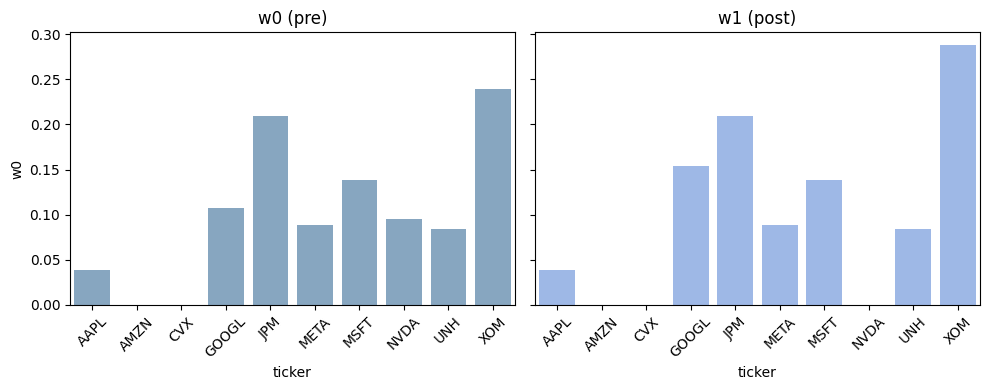

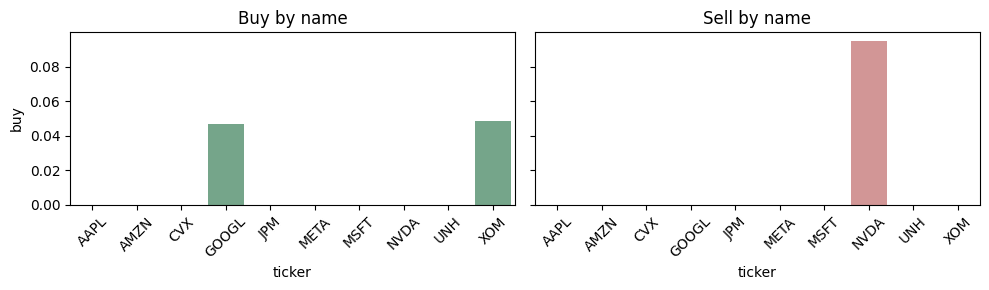

In [434]:
params["name_cap"] = 1
res_reb = solve_rebalance_mean_cvar(ret, sectors, params)
show_rebalance_results(res_reb, sectors)

Rebalance post-portfolio VaR/CVaR
Mean loss: -0.001121
VaR 0.95: 0.014875
CVaR 0.95: 0.022032
Max loss: 0.058005


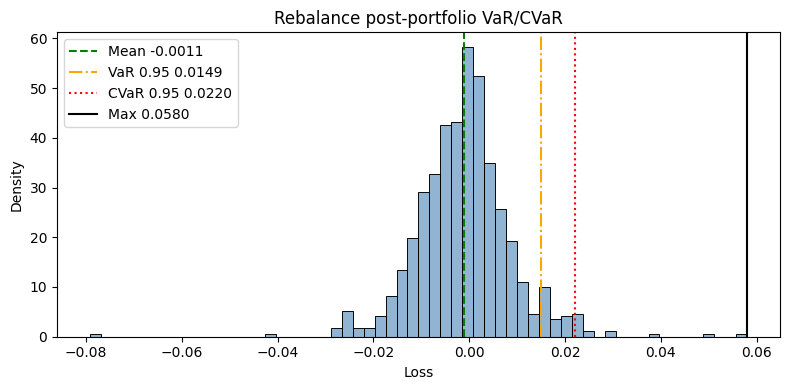

In [435]:
show_portfolio_cvar_rebalance(ret, res_reb, alpha=params["alpha"], title="Rebalance post-portfolio VaR/CVaR")

## **3.3 Interpretation of Results**
* **Risk/return**: It meets the full-horizon return target (~0.001104/day, expected loss −0.001104). Tail risk tightens to VaR ≈ 0.01487 and CVaR(loss) ≈ 0.02201, so the average loss in the worst 5% of days is about 2.2%.

* **Objective**: The loss-based objective (expected loss + CVaR + costs) is ~0.01814, lower is better given the chosen λ weights.

* **Allocation shifts**: Most names stay steady; the meaningful moves are selling NVDA (0.094 → 0) and buying GOOGL (0.108 → 0.155) and XOM (0.241 → 0.288). Others stay put (JPM, MSFT, META, UNH, AAPL).
Sector mix (post): Energy ~28.8%, Comm Services ~24.3%, Financials ~20.8%, Technology ~17.8%, Healthcare ~8.3%, Consumer Cyclical 0.

* **Turnover/costs**: Turnover is modest (~0.187), reflecting those targeted trades; costs are already baked into the objective. If costs were higher, you’d see less movement; if they were zero, the model could move more.
Caps/feasibility: No name or sector caps bind, so the improvement comes from reallocation rather than constraint relaxation. Budgets remain fully invested pre/post; the CVaR is computed on losses over the whole horizon (w0 before day 375, w1 after).

* **Takeaway**: A single planned rebalance at the midpoint trims tail loss without giving up return, driven by a focused shift away from a higher-tail-loss name (NVDA) toward names with better tail behavior (GOOGL, XOM), all within the existing limits and with modest trading.


## **3.4 Comparison to Baseline Model**
* The rebalance run comes out slightly more optimal because it has one extra degree of freedom: it can hold a pre‑k portfolio and then reshape at k to better fit the post‑k return distribution. With modest turnover and costs in the objective, the solver uses that flexibility to nudge risk out of the tail without sacrificing the return floor. The result is a lower tail loss (CVaR) and a better overall risk score, paid for by a small, targeted trade.

* This is not guaranteed to always beat the static baseline. If costs were higher, the post‑k window looked similar to the pre‑k window, or caps were binding, the benefit could shrink or even disappear. Here, the post period is different enough and costs low enough that a single planned rebalance improves the tail profile.

* Overall, if you keep the constraints aligned (same return target, caps, scenarios), keep costs in the objective, and allow zero trades; then the rebalance solve will be equal to or better than baseline.

* Add expected value into the problem
* Make one general model and then test it with different params
* The notebook should be like a story throughout
* Comapre what if we had no expected weight

* Chance constraint
* Robust constraint